# test the low-rank approximation 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from scipy import signal
from scipy.sparse import linalg as sla
from scipy import sparse

from scipy import linalg as la
from tqdm import tqdm
from scipy.optimize import minimize

from oceanoi import cov, oi, variogram

In [ ]:
%%time
np.random.seed(1) # this generates the same output every time
# Generate some training data

#########
# Parameters
noise = 0.01
covfunc = cov.expquad_1d
covparams = (0.15, 1.6)
dx = 0.8
N = 12000

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N//10)

K = covfunc(xd[:,None], xd[:,None].T, covparams)

CPU times: user 16.1 s, sys: 1.51 s, total: 17.6 s
Wall time: 6.96 s


(12000,)

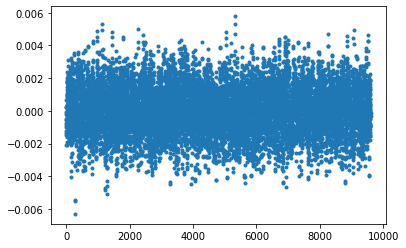

In [88]:
%%time
L = la.cholesky(K+1e-7*np.eye(N))
yd = L.dot(noise*np.random.normal(size=(N,)))

#mu = np.zeros_like(xd)
#yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()+noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd, yd,'.')
xd.shape

CPU times: user 25.7 s, sys: 3.43 s, total: 29.1 s
Wall time: 11.8 s


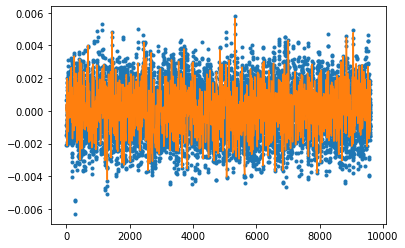

In [77]:
%%time
# Create a 1D OI object

scale = 1

OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

In [83]:
import scipy.linalg.interpolative as sli
from scipy.sparse.linalg import aslinearoperator

def rand_svd(K, r):
    
    n = K.shape[0]
    omega = np.random.randn(n,r)

    Y = K@omega # n x r
    QT,R = la.qr(Y, mode='economic')
    B = QT.T @ Y # r x r
    Uhat, S, VT = la.svd(B)
    U = Q @ Uhat
    
    return U, S, VT

def inv_lowrank(Kdd, sigma, k, method='sparse', threshold=1e-5):
    """
    Matrix inversion using the low rank approximation
    """
    
    if method=='sparse':
        print('Using sparse matrix approximation...')
        # Use the sparse linalg library
        
        print('Creating sparse matrix...')
        idx = np.abs(Kdd)>threshold
        R,C = np.where(idx)
        Kdd_s = sparse.coo_matrix((Kdd[idx], (R,C)), shape=Kdd.shape)
        
        print('Computing svd...')
        Uh,Sh,VhT = sla.svds(Kdd_s, k=k, which='LM', solver='lobpcg')

        # Note that these are reversed order
        #Uh = Uh[:,::-1]
        #Vh = Vh[::-1,:] # V is transposed
        #Sh = Sh[::-1]
        
    elif method=='rand':
        print('Using random matrix svd...')
        Uh, S, VhT = rand_svd(K, k)
        
    elif method=='scipy':
        print('Using scipy dense matrix svd...')
        U, S, V = la.svd(Kdd, check_finite=False, overwrite_a=False)
        Uh = U[:,0:k]
        Sh = S[0:k]
        VhT = V[:,0:k].T
    
    print('Inverting using woodman...')
    # Inverse
    N = Uh.shape[0]

    I = np.ones((N,))
    #Si = np.diag(1/Sh)
    #Ai = np.diag(1/(sigma*I))
    
    Si = sparse.spdiags(1/Sh,0,k,k)
    Ai = sparse.spdiags(1/(sigma*I),0,N,N)
    
    B =  Si + VhT @ Ai @ Uh
    Bi = la.inv(B)

    Ki = Ai - Ai @ Uh @ Bi @ VhT @ Ai
    
    return Ki, Sh

def inv_lowrank2(Kdd, sigma, k, method='sparse'):
    """
    Matrix inversion using the low rank approximation
    """
    
    #     if method=='sparse':
    #         # Use the sparse linalg library
    #         Uh,Sh,VhT = sla.svds(Kdd, k=k, which='LM')

    #         # Note that these are reversed order
    #         #Uh = Uh[:,::-1]
    #         #Vh = Vh[::-1,:] # V is transposed
    #         #Sh = Sh[::-1]
    #     elif method=='scipy':
    #print('using low rank...')
    M = Kdd.shape[0]
    #U, S, V = la.svd(Kdd, check_finite=False, overwrite_a=False)
    
    #U, S, V = sli.svd(Kdd, k)
    
    L = aslinearoperator(Kdd)
    U, S, V = sli.svd(L, k)
    #idx, proj = sli.interp_decomp(L, k)
    #B = sli.reconstruct_skel_matrix(Kdd, k, idx)
    #U, S, V = sli.id_to_svd(B, idx, proj)

    #print('done')
    Uh = U[:,0:k]
    Sh = S[0:k]
    VhT = V[:,0:k].T
    
    # Inverse
    N = Uh.shape[0]
    #print(N)
    I = np.ones((N,))
    #Si = np.diag(1/Sh)
    #Ai = np.diag(1/(sigma*I))
    Si = sparse.spdiags(1/Sh,0,k,k)
    Ai = sparse.spdiags(1/(sigma*I),0,N,N)
    
    B =  Si + VhT @ Ai @ Uh
    #print('inverting B')
    Bi = la.inv(B)
    #print('done',B.shape,Bi.shape)

    Ki = Ai - Ai @ Uh @ Bi @ VhT @ Ai
    #print('done',Ki.shape)
    return Ki, Sh
    
    

In [84]:
class OptimalInterpLowRank(oi.OptimalInterp1D):
    
    def __init__(self, xd, xm, sd, cov_func, cov_params, k=100):
        
        self.k = k

        oi.OptimalInterp1D.__init__(self,xd, xm, sd, cov_func, cov_params)
         
    def __call__(self, yd):
        return np.dot(self.w_md.T, yd)
    
    def _calc_weights(self, K, sd, Ks):
        print(sd[0,0])
        Ki, Sh = inv_lowrank(K, sd[0,0], self.k,method='sparse')
        print(self.N, self.k, Ki .shape, K.shape, Ks.shape)
        w= np.dot(Ks, Ki).T
        print(w.shape)
        return None, w


In [86]:
%%time
scale = 1

OI = OptimalInterpLowRank(xd*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams, k=10)

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

0.0001
Using sparse matrix approximation...
Creating sparse matrix...
Computing svd...
Inverting using woodman...
12000 10 (12000, 12000) (12000, 12000) (1200, 12000)
(12000, 1200)
CPU times: user 15.5 s, sys: 3.49 s, total: 19 s
Wall time: 10.8 s


In [53]:
Kdd = OI.Kdd
threshold = 1e-5
idx = np.abs(Kdd)>threshold
np.sum(idx), np.prod(Kdd.shape)
R,C = np.where(idx)
Kdd_s = sparse.coo_matrix((Kdd[idx], (R,C)), shape=Kdd.shape)
Kdd_s

<2500x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 37444 stored elements in COOrdinate format>

In [20]:
# Test the random projection method to calculate the SVD of the covariance matrix K
K = OI.Kdd
K.shape

(2500, 2500)

In [44]:
r = 100
n = K.shape[0]
omega = np.random.randn(n,r)

Y = K@omega # n x r
QT,R = la.qr(Y, mode='economic')
B = QT.T @ Y # r x r
Uhat, S, VT = la.svd(B)
U = Q @ Uhat

# Test the Nystrom approximation to K^-1

See here:  

https://maelfabien.github.io/machinelearning/largescale/#in-python-2

https://boostedml.com/2020/08/the-nystrom-method-for-finding-eigenpairs-of-a-kernel-function.html